In [1]:
import prior

dataset = prior.load_dataset("procthor-10k")
dataset

Fetching reference HEAD


[AI2-THOR WARNING] There has been an update to ProcTHOR-10K that must be used with AI2-THOR version 5.0+. To use the new version of ProcTHOR-10K, please update AI2-THOR to version 5.0+ by running:
    pip install --upgrade ai2thor
Alternatively, to downgrade to the old version of ProcTHOR-10K, run:
   prior.load_dataset("procthor-10k", revision="ab3cacd0fc17754d4c080a3fd50b18395fae8647")


Loading test: 100%|██████████| 1000/1000 [00:00<00:00, 22321.41it/s]


DatasetDict(
    train=Dataset(
    dataset=procthor-dataset,
    size=10000,
    split=train
),
    val=Dataset(
    dataset=procthor-dataset,
    size=1000,
    split=val
),
    test=Dataset(
    dataset=procthor-dataset,
    size=1000,
    split=test
)
)

In [537]:
from ai2thor.controller import Controller
import torch

ACTIONS = ["MoveAhead", "RotateLeft", "RotateRight"]
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
house = dataset["train"][5]
controller = Controller(scene=house, snapToGrid=False, rotateStepDegrees=30)

In [538]:
import clip

model, preprocess = clip.load("ViT-B/32", device=DEVICE)

In [539]:
from PIL import Image
last_action_fail = False
embeddings = []

def event_to_embed(event, model):
    img = Image.fromarray(event.frame)
    with torch.no_grad():
        x = preprocess(img).unsqueeze(0).to(DEVICE)
        emb = model.encode_image(x).squeeze(0)
        emb = emb / emb.norm(dim=-1, keepdim=True)
        return emb

n = 0
for i in range(250):
    if last_action_fail:
        dist = torch.distributions.Categorical(probs=torch.tensor([0,0.5,0.5]))
    else:
        dist = torch.distributions.Categorical(probs=torch.tensor([0.5,0.25,0.25]))
    
    action = ACTIONS[dist.sample()]
    event = controller.step(action)
    last_action_fail = not event.metadata["lastActionSuccess"]

    # sample every 4 frames
    if i % 4 == 0:
        img = Image.fromarray(event.frame)
        embeddings.append(event_to_embed(event, model))
        img.save("data/image" + str(n) + ".png")
        n += 1


In [540]:
import faiss
import numpy as np

def save_to_db(index, embeddings):    
    data = np.stack(embeddings).astype('float32')  # shape (N, 512)
    index.add(data)
    print("Index contains:", index.ntotal, "items")

index = faiss.IndexFlatL2(512)  # simple L2 index
save_to_db(index, embeddings)

Index contains: 63 items


[[98.516136 98.62713  98.6417   98.673965 98.80231  98.80696 ]]


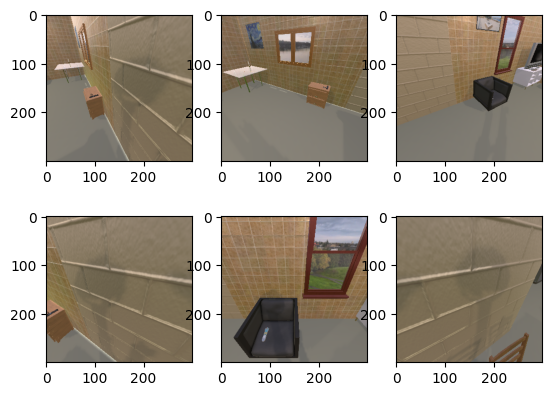

In [541]:
import matplotlib.pyplot as plt
n_images = 6
query_search = "Door"
with torch.no_grad():
    text_tokens = clip.tokenize([query_search]).to(DEVICE)
    encoded_text_tokens = model.encode_text(text_tokens)
    similarity, result = index.search(encoded_text_tokens, n_images)
    print(similarity)
    for i in range(1, n_images + 1):
        im = Image.open("data/image" + str(result[0][i - 1]) + ".png")

        plt.subplot(2, 3, i)
        plt.imshow(im)

In [536]:
controller.stop()